In [1]:
import math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

Text(0, 0.5, 'TPR')

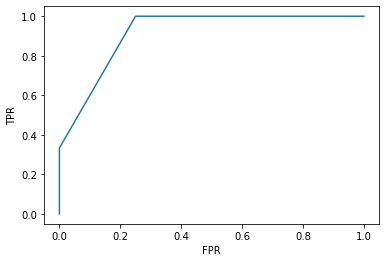

In [7]:
# problem 5 drawing ROC curve
FPR = [0,0,0.25,0.5,1]
TPR = [0,1/3,1,1,1]
plt.plot(FPR,TPR)
plt.xlabel("FPR")
plt.ylabel("TPR")

In [16]:
#KNN algorithm 
def euclidean_distance(point1, point2):
    point2 = np.array(point2)[0:2]
    return np.linalg.norm(point1 - point2)

def get_neighbors(train, test_row, num_neighbors):
    distances = list()
    for index, train_row in train.iterrows():
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = []
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

def predict_classification(train, test_row, num_neighbors):
    neighbors = get_neighbors(train, test_row, num_neighbors)
    output_values = [row[-1] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction

def k_nearest_neighbors(train, test, num_neighbors):
    predictions = []
    for row in test:
        output = predict_classification(train, row, num_neighbors)
        predictions.append(output)
    return(predictions)

In [49]:
#log regression algo
def sigmoid(z):
    return 1.0/(1 + np.exp(-z))

def loss(y, y_hat):
    loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))
    return loss

def gradients(X, y, y_hat):
    m = X.shape[0]
    #gradient with respect to weight and bias
    dw = (1/m)*np.dot(X.T, (y_hat - y))
    db = (1/m)*np.sum((y_hat - y)) 
    return dw, db

def train(X, y, bs, epochs, lr):
    X = np.array(X)
    y = np.array(y)
    m, n = X.shape
    
    # Initializing weights and bias to zeros.
    w = np.zeros((n,1))
    b = 0
    
    # Reshaping y.
    y = y.reshape(m,1)
    # Empty list to store losses.
    losses = []
    
    for epoch in range(epochs):
        for i in range((m-1)//bs + 1):
            
            # Defining batches. SGD.
            start_i = i*bs
            end_i = start_i + bs
            xb = X[start_i:end_i]
            yb = y[start_i:end_i]
            
            # Calculating hypothesis/prediction.
            y_hat = sigmoid(np.dot(xb, w) + b)
            
            # Getting the gradients of loss w.r.t parameters.
            dw, db = gradients(xb, yb, y_hat)
            
            # Updating the parameters.
            w -= lr*dw
            b -= lr*db
        
        # Calculating loss and appending it in the list.
        l = loss(y, sigmoid(np.dot(X, w) + b))
        losses.append(l)
        
    # returning weights, bias and losses(List).
    return w, b, losses

#prediction threshold = 0.5
def predict(X,w,b):
    preds = sigmoid(np.dot(X, w) + b) 
    # Empty List to store predictions.
    pred_class = []
    pred_class = [1 if i > 0.5 else 0 for i in preds]
    return np.array(pred_class)

def accuracy(y, y_hat):
    accuracy = np.sum(y == y_hat) / len(y)
    return accuracy

In [23]:
df = pd.read_csv('data\D2z.txt', sep=" ", header=None)
df.columns = ['x1', 'x2', 'y']
cols = df.columns
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
x1_test = []
x2_test = []
#generate the grid
for i, vi in enumerate(np.arange(-2, 2.1, 0.1)):
        for j, vj in enumerate(np.arange(-2, 2.1, 0.1)):
            x1_test.append(vi)
            x2_test.append(vj)
x1_test = np.array(x1_test)
x2_test = np.array(x2_test)
test = np.vstack((x1_test, x2_test)).T

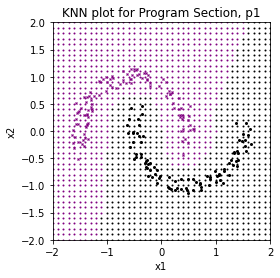

In [24]:
pred = np.array(k_nearest_neighbors(df, test, 1))
test = np.append(test, pred.reshape(len(pred),1), 1)


x1_test_neg = test[test[:, 2]==0][:, 0]
x2_test_neg = test[test[:, 2]==0][:, 1]

x1_test_pos = test[test[:, 2]==1][:, 0]
x2_test_pos = test[test[:, 2]==1][:, 1]

x1_train_pos = np.array(df[df['y'] == 1]['x1'])
x2_train_pos = np.array(df[df['y'] == 1]['x2'])
x1_train_neg = np.array(df[df['y'] == 0]['x1'])
x2_train_neg = np.array(df[df['y'] == 0]['x2'])

fig, ax = plt.subplots()
plt.title("KNN plot for Program Section, p1")
plt.xlabel('x1')
plt.ylabel('x2')
plt.plot(x1_test_pos, x2_test_pos, '.', color='purple', markersize=2)
plt.plot(x1_test_neg, x2_test_neg, '.', color='black', markersize=2)
plt.plot(x1_train_pos, x2_train_pos, 'x', color='purple', markersize=2)
plt.plot(x1_train_neg, x2_train_neg, 'o', color='black', markersize=2)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
ax.set_aspect('equal')
plt.show()

In [35]:
df = pd.read_csv('data\emails.csv', sep=",")
# Dropping the 1st column because it contains index
df = df.drop(columns=df.columns[0])
# Creating the individual splits
fold1_train = df.iloc[:1000, :]
fold1_test = df.iloc[1000:, :]

fold2_train = df.iloc[1000:2000, :]
fold2_test = pd.concat([df.iloc[:1000, :], df.iloc[2000:, :]])

fold3_train = df.iloc[2000:3000, :]
fold3_test = fold2_test = pd.concat([df.iloc[:2000, :], df.iloc[3000:, :]])

fold4_train = df.iloc[3000:4000, :]
fold4_test = fold2_test = pd.concat([df.iloc[:3000, :], df.iloc[4000:, :]])

fold5_train = df.iloc[4000:5000, :]
fold5_test = df.iloc[:3000, :]

foldmain_train = df.iloc[:4000, :]
foldmain_test = df.iloc[4000:5000, :]

In [42]:
#use sklearn KNN here cause it runs faster
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(fold1_train.iloc[:, :-1], fold1_train.iloc[:, -1])
y_pred = neigh.predict(fold1_test.iloc[:, :-1])
print("Accuracy fold1: " + str(accuracy_score(fold1_test.iloc[:, -1], y_pred)))
print("Precision fold1: " + str(precision_score(fold1_test.iloc[:, -1], y_pred, average='binary')))
print("Recall fold1: " + str(recall_score(fold1_test.iloc[:, -1], y_pred, average='binary')))
    
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(fold2_train.iloc[:, :-1], fold2_train.iloc[:, -1])
y_pred = neigh.predict(fold2_test.iloc[:, :-1])
print("Accuracy fold2: " + str(accuracy_score(fold2_test.iloc[:, -1], y_pred)))
print("Precision fold2: " + str(precision_score(fold2_test.iloc[:, -1], y_pred, average='binary')))
print("Recall fold2: " + str(recall_score(fold2_test.iloc[:, -1], y_pred, average='binary')))

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(fold3_train.iloc[:, :-1], fold3_train.iloc[:, -1])
y_pred = neigh.predict(fold3_test.iloc[:, :-1])
print("Accuracy fold3: " + str(accuracy_score(fold3_test.iloc[:, -1], y_pred)))
print("Precision fold3: " + str(precision_score(fold3_test.iloc[:, -1], y_pred, average='binary')))
print("Recall fold3: " + str(recall_score(fold3_test.iloc[:, -1], y_pred, average='binary')))

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(fold4_train.iloc[:, :-1], fold4_train.iloc[:, -1])
y_pred = neigh.predict(fold4_test.iloc[:, :-1])
print("Accuracy fold4: " + str(accuracy_score(fold4_test.iloc[:, -1], y_pred)))
print("Precision fold4: " + str(precision_score(fold4_test.iloc[:, -1], y_pred, average='binary')))
print("Recall fold4: " + str(recall_score(fold4_test.iloc[:, -1], y_pred, average='binary')))

neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(fold5_train.iloc[:, :-1], fold5_train.iloc[:, -1])
y_pred = neigh.predict(fold5_test.iloc[:, :-1])
print("Accuracy fold5: " + str(accuracy_score(fold5_test.iloc[:, -1], y_pred)))
print("Precision fold5: " + str(precision_score(fold5_test.iloc[:, -1], y_pred, average='binary')))
print("Recall fold5: " + str(recall_score(fold5_test.iloc[:, -1], y_pred, average='binary')))

Accuracy fold1: 0.78875
Precision fold1: 0.6276252019386107
Recall fold1: 0.6692506459948321
Accuracy fold2: 0.8275
Precision fold2: 0.6661870503597123
Recall fold2: 0.8038194444444444
Accuracy fold3: 0.78675
Precision fold3: 0.6075156576200418
Recall fold3: 0.7512908777969018
Accuracy fold4: 0.76725
Precision fold4: 0.5714285714285714
Recall fold4: 0.7673611111111112
Accuracy fold5: 0.7373333333333333
Precision fold5: 0.5266544117647058
Recall fold5: 0.6773049645390071


In [50]:
w1, b1, l = train(fold1_train.iloc[:, :-1], fold1_train.iloc[:,-1], bs=100, epochs=500, lr=0.02)
predicted_c = predict(fold1_test.iloc[:, :-1],w1,b1)
print("1fold Accuracy"+str(accuracy(np.array(fold1_test.iloc[:, -1]),predicted_c)))
print("1fold Precision " + str(precision_score(np.array(fold1_test.iloc[:, -1]),predicted_c, average='binary')))
print("1fold Recall " + str(recall_score(np.array(fold1_test.iloc[:, -1]),predicted_c, average='binary')))

w2, b2, l = train(fold1_train.iloc[:, :-1], fold2_train.iloc[:,-1], bs=100, epochs=500, lr=0.02)
predicted_c = predict(fold2_test.iloc[:, :-1],w2,b2)
print("2fold Accuracy"+str(accuracy(np.array(fold2_test.iloc[:, -1]),predicted_c)))
print("2fold Precision " + str(precision_score(np.array(fold2_test.iloc[:, -1]),predicted_c, average='binary')))
print("2fold Recall " + str(recall_score(np.array(fold2_test.iloc[:, -1]),predicted_c, average='binary')))

w3, b3, l = train(fold3_train.iloc[:, :-1], fold3_train.iloc[:,-1], bs=100, epochs=500, lr=0.02)
predicted_c = predict(fold3_test.iloc[:, :-1],w3,b3)
print("3fold Accuracy"+str(accuracy(np.array(fold3_test.iloc[:, -1]),predicted_c)))
print("3fold Precision " + str(precision_score(np.array(fold3_test.iloc[:, -1]),predicted_c, average='binary')))
print("3fold Recall " + str(recall_score(np.array(fold3_test.iloc[:, -1]),predicted_c, average='binary')))

w4, b4, l = train(fold4_train.iloc[:, :-1], fold4_train.iloc[:,-1], bs=100, epochs=500, lr=0.02)
predicted_c = predict(fold4_test.iloc[:, :-1],w4,b4)
print("4fold Accuracy"+str(accuracy(np.array(fold4_test.iloc[:, -1]),predicted_c)))
print("4fold Precision " + str(precision_score(np.array(fold4_test.iloc[:, -1]),predicted_c, average='binary')))
print("4fold Recall " + str(recall_score(np.array(fold4_test.iloc[:, -1]),predicted_c, average='binary')))

w5, b5, l = train(fold5_train.iloc[:, :-1], fold5_train.iloc[:,-1], bs=100, epochs=500, lr=0.02)
predicted_c = predict(fold5_test.iloc[:, :-1],w5,b5)
print("5fold Accuracy"+str(accuracy(np.array(fold5_test.iloc[:, -1]),predicted_c)))
print("5fold Precision " + str(precision_score(np.array(fold5_test.iloc[:, -1]),predicted_c, average='binary')))
print("5fold Recall " + str(recall_score(np.array(fold5_test.iloc[:, -1]),predicted_c, average='binary')))

<ipython-input-49-0cfde8dbbc00>:3: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-z))
<ipython-input-49-0cfde8dbbc00>:6: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))
<ipython-input-49-0cfde8dbbc00>:6: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))


1fold Accuracy0.90025
1fold Precision 0.8371681415929203
1fold Recall 0.8148148148148148


<ipython-input-49-0cfde8dbbc00>:3: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-z))
<ipython-input-49-0cfde8dbbc00>:6: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))
<ipython-input-49-0cfde8dbbc00>:6: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))


2fold Accuracy0.70975
2fold Precision 0.2631578947368421
2fold Recall 0.004340277777777778


<ipython-input-49-0cfde8dbbc00>:3: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-z))
<ipython-input-49-0cfde8dbbc00>:6: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))
<ipython-input-49-0cfde8dbbc00>:6: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))


3fold Accuracy0.91275
3fold Precision 0.8178264268960125
3fold Recall 0.9001721170395869


<ipython-input-49-0cfde8dbbc00>:3: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-z))
<ipython-input-49-0cfde8dbbc00>:6: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))
<ipython-input-49-0cfde8dbbc00>:6: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))


4fold Accuracy0.91675
4fold Precision 0.8502994011976048
4fold Recall 0.8628472222222222


<ipython-input-49-0cfde8dbbc00>:3: RuntimeWarning: overflow encountered in exp
  return 1.0/(1 + np.exp(-z))
<ipython-input-49-0cfde8dbbc00>:6: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))
<ipython-input-49-0cfde8dbbc00>:6: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))


5fold Accuracy0.915
5fold Precision 0.8472385428907168
5fold Recall 0.8522458628841607


In [46]:
avrg_accuracy = []
for i in [1,3,5,7,10]:
    accuracies = []
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(fold1_train.iloc[:, :-1], fold1_train.iloc[:, -1])
    y_pred = neigh.predict(fold1_test.iloc[:, :-1])
    accuracies.append(accuracy_score(fold1_test.iloc[:, -1], y_pred))

    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(fold2_train.iloc[:, :-1], fold2_train.iloc[:, -1])
    y_pred = neigh.predict(fold2_test.iloc[:, :-1])
    accuracies.append(accuracy_score(fold2_test.iloc[:, -1], y_pred))

    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(fold3_train.iloc[:, :-1], fold3_train.iloc[:, -1])
    y_pred = neigh.predict(fold3_test.iloc[:, :-1])
    accuracies.append(accuracy_score(fold3_test.iloc[:, -1], y_pred))

    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(fold4_train.iloc[:, :-1], fold4_train.iloc[:, -1])
    y_pred = neigh.predict(fold4_test.iloc[:, :-1])
    accuracies.append(accuracy_score(fold4_test.iloc[:, -1], y_pred))

    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(fold5_train.iloc[:, :-1], fold5_train.iloc[:, -1])
    y_pred = neigh.predict(fold5_test.iloc[:, :-1])
    accuracies.append(accuracy_score(fold5_test.iloc[:, -1], y_pred))
    
    avrg_accuracy.append(sum(accuracies)/5)

Text(0.5, 1.0, 'knn accuracy vs #of neighbors plot')

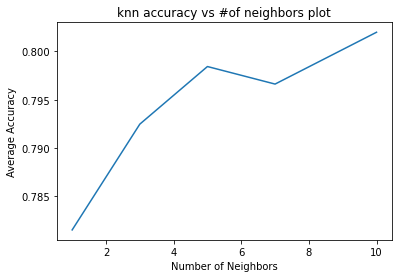

In [47]:
#knn accuracy vs #of neighbors plot
plt.plot([1,3,5,7,10],avrg_accuracy)
plt.xlabel("Number of Neighbors")
plt.ylabel("Average Accuracy")
plt.title("knn accuracy vs #of neighbors plot")

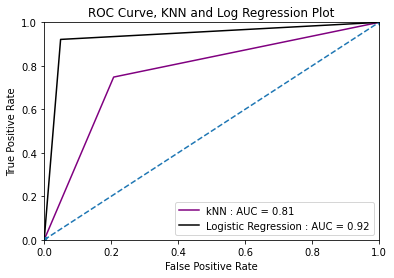

In [54]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(foldmain_train.iloc[:, :-1], foldmain_train.iloc[:, -1])
y_pred = neigh.predict(foldmain_test.iloc[:, :-1])
fpr_knn, tpr_knn, threshold = roc_curve(foldmain_test.iloc[:, -1], y_pred)

lr = LogisticRegression(max_iter=1000)
lr.fit(foldmain_train.iloc[:, :-1], foldmain_train.iloc[:,-1])
predicted_classes = lr.predict(foldmain_test.iloc[:, :-1])
fpr_log, tpr_log, threshold = roc_curve(foldmain_test.iloc[:, -1], predicted_classes)

plt.title('ROC Curve, KNN and Log Regression Plot')
plt.plot(fpr_knn, tpr_knn, 'b', color="purple", label="kNN : AUC = 0.81")
plt.plot(fpr_log, tpr_log, 'b', color="black", label="Logistic Regression : AUC = 0.92")

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'v--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()